In [0]:
import os
from sklearn.externals import joblib
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
from sklearn.model_selection import train_test_split
from IPython.display import display

from sklearn.metrics import confusion_matrix, accuracy_score
np.seterr(invalid='raise')
%matplotlib inline


def save_model(net, X_train, y_train, X_test, y_test,
               path="gdrive/My Drive/ColabNotebooks/weights_mlp/", 
               test_acc=None, train_acc=None):
    assert(os.path.isdir(path))
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M')
    path = os.path.join(path, f"{current_time}")
    if not os.path.isdir(path):
        os.mkdir(path)
    joblib.dump(net, os.path.join(path, "net.pkl"))
    text_file = open(os.path.join(path, "info.txt"), "w")
    
    if not test_acc:
      test_acc = compute_acc(X_test,y_test,net), 
    if not train_acc:
      train_acc = compute_acc(X_train,y_train,net)
      
    print(round(test_acc, 6), file=text_file)
    print(round(train_acc, 6), file=text_file)
    text_file.close()
    
def load_model(path):
    """
    path -- path to directory named like  %Y-%m-%d %H:%M with model and 
    info.txt file
    """
    assert(os.path.isdir(path))
    return joblib.load(os.path.join(path, "net.pkl"))

def load_last_model(path="gdrive/My Drive/ColabNotebooks/weights_mlp/"):
    """
    path -- path to directory with directories name like %Y-%m-%d %H:%M
    in these directories lies files with pickled models
    
    returns -- last saved model
    """
    assert(os.path.isdir(path))
    dirs = os.listdir(path)
    format = '%Y-%m-%d %H:%M'
    dirs = [datetime.strptime(x, format) for x in dirs]
    dirs.sort(reverse=True)
    return load_model(os.path.join(path, dirs[0].strftime(format)))

def load_best_model(path="gdrive/My Drive/ColabNotebooks/weights_mlp/"):
    assert(os.path.isdir(path))
    dirs = os.listdir(path)
    dirs = [x for x in dirs if os.path.isdir(os.path.join(path, x))]
    print
    test_acc = []
    for _dir in dirs:
      file_name = os.path.join(os.path.join(path, _dir), "info.txt")
      if os.path.isfile(file_name):
        text_file = open(file_name, "r")
        test_acc.append(text_file.readline())
      
    dirs = [(x, y) for x, y in zip(dirs, test_acc)]
    dirs.sort(key = lambda x: x[1], reverse = True)
    return load_model(os.path.join(path, dirs[0][0]))    

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!ls "gdrive/My Drive/ColabNotebooks"

Homework2_perceptron.ipynb  mnist_data	my_submission.csv  weights_mlp


In [0]:
class OneHotEncoder:
    """
    класс one-hot encoder'а для MNIST
    
    """
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]
      

def make_submission(X_test: np.ndarray, net: MnistNet, fname="my_submission.csv"):
    from os.path import join
    with open(join("gdrive/My Drive/ColabNotebooks", fname),'w') as fout:
        fout.write('Id,Category')
        
        error_counter = 0
        for i in range(X_test.shape[0]):
            try:
                y_h = net.forward(X_test[i])
            except Exception:
                error_counter += 1
                y_h = np.array([1,0,0,0,0,0,0,0,0,0])
            
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))
        print(error_counter)
def compute_acc(X_test: np.ndarray, Y_test: np.ndarray, net: MnistNet) -> float:
    """
    Y_test -- one hoted labels to the X_test dataset
    returns -- accuracy of predictions of net on X_test, Y_test
    """
    assert(X_test.shape[0] == Y_test.shape[0])
    assert(Y_test.shape[1] == 10)
    assert(X_test.shape[1] == 784)
    
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == np.argmax(Y_test[i])):
            acc += 1.0
    return acc / Y_test.shape[0]
  
def my_confusion_matrix(X: np.ndarray, y: np.ndarray, net: MnistNet):
    """
    returns -- confusion matrix of prediction of net on X, y dataset
    """
    preds = np.ndarray(shape=(0, 1))
    y_true = np.ndarray(shape=(0, 1))
    for row_x, row_y in zip(X, y):
        y_h = net.forward(row_x)
        preds = np.vstack((preds, np.argmax(y_h).reshape((1,1))))
        y_true = np.vstack((y_true, np.argmax(row_y).reshape((1,1))))
    
    return confusion_matrix(y_true, preds)
  
    
def shuffle(x: np.ndarray, y: np.ndarray):
    assert(x[:, 0].shape[0] == y[:, 0].shape[0])
    p = np.random.permutation(x.shape[0])
    return x[p], y[p]

In [0]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('gdrive/My Drive/ColabNotebooks/mnist_data/data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('gdrive/My Drive/ColabNotebooks/mnist_data/data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_labels = train_data['data']
Y_labels = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_labels)))

X_labels = X_labels.astype('float')
Xm = np.mean(X_labels, axis=0)
Xs = np.std(X_labels, axis=0)
X_labels=(X_labels - Xm) / (Xs + 0.01)

X_site = test_data['data']
X_site = X_site.astype('float')
X_site=(X_site - Xm) / (Xs + 0.01)

X_train,X_test,y_train,y_test= train_test_split(X_labels,Y_train_oh,
                                                test_size=0.3, stratify=Y_labels)

In [8]:
# проверяем, что классы разбиты примерно поравну в обучающей и тестовой выборках
display(np.sum(y_train, axis=0))
display(np.sum(y_test, axis=0))

array([3624., 4136., 3669., 3749., 3583., 3314., 3610., 3829., 3583.,
       3653.])

array([1553., 1772., 1573., 1607., 1535., 1421., 1547., 1641., 1536.,
       1565.])

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36750, 784)
(36750, 10)
(15750, 784)
(15750, 10)


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


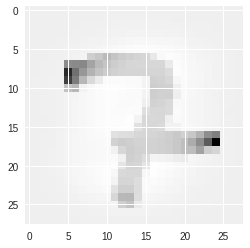

In [17]:
def show(i):
    try:
        print(y_train[i])
        plt.imshow(X_train[i, :].reshape(28,28))
    except IndexError:
        print(y_train[0, i])
        plt.imshow(X_train[:, i].reshape(28,28))
        
        
        
show(3)

In [0]:
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2/(out_size + in_size))
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr: int):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W -= lr * self.dW
        self.b -= lr * self.db

        # возвращаем dx для продолжения алгоритма
        return self.dx
    

class Max:
    
    def forward(self, x):
        
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz  

class Dropout:
    def __init__(self, p = 0.25):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        if not self.train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask
    
class Softmax:
    
    def forward(self, x):
        self.x = x
        exps = np.exp(x)
        return exps/np.sum(exps)
        
    def backward(self, dz, lr=0.001):
        sm = self.forward(self.x)
        self.lp= (np.eye(sm.shape[0],sm.shape[0])-sm).T
        self.lp1=  sm*self.lp 
        return np.dot(dz,self.lp1)
    
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum(y_true * np.log(y_hat+0.0001))
    
    def backward(self, dz=1):
        return  dz * self.y_true / (self.y_hat+0.0001)* (-1.)

In [25]:
loss = CrossEntropy()
loss.forward(np.array([0.5]), np.array([[0]]))

4.605170185988091

In [0]:
class MnistNet:
    
    def __init__(self, rlambda=None):
        self.layers = []
        self.layers.append(Dense(784, 512))
        self.layers.append(Dropout())
        self.layers.append(Max())
        
        self.layers.append(Dense(512,256))
        self.layers.append(Dropout())
        self.layers.append(Max())
        
        self.layers.append(Dense(256,128))
        self.layers.append(Dropout())
        self.layers.append(Max())
        
        self.layers.append(Dense(128,10))
        self.layers.append(Softmax())
        
        if rlambda:
            Denses = [layer for layer in self.layers if isinstance(layer, Dense)]
            assert(len(rlambda) == len(Denses))
            for dense, _rlabmda in Denses, rlambda:
                dense.rlambda = _rlabmda
        
    def set_train(self, train: bool):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                layer.set_train(train)
        
    def forward(self, x):
        net = x
        for layer in self.layers:
            net = layer.forward(net)
        return net
    
    def backward(self, dz, *lr):
        for index, layer in zip(range(len(self.layers) - 1, -1, -1), self.layers[::-1]):
            dz = layer.backward(dz, lr[index])
        return dz

In [0]:
def train(net: MnistNet, epoch: int, X_train: np.ndarray, 
          y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, 
          _lr: int):
    """
    net -- neural network of class MnistNet that will be trained via gradient
    descent on X_train and y_train dataset
    X_test, y_test -- dev dataset to compute accuracy
    epoch -- number of iteration through the whole dataset
    _lr -- learning rate for gradient descent
        
    returns -- trained neural network net
    """
    assert(_lr > 0 and epoch > 0)
    
    acc_train, acc_test = [], []
    
    loss = CrossEntropy()
    lr = [_lr] * len(net.layers)
    for iter in tqdm.tqdm_notebook(range(1, epoch + 1)):
        net.set_train(True)
        
        X_train_shuffled, Y_train_shuffled = shuffle(X_train, y_train)
        for i in tqdm.tqdm_notebook(range(X_train_shuffled.shape[0])):
            X = X_train_shuffled[i, :]
            Y = Y_train_shuffled[i, :]

            y_h = net.forward(X)
            _ = loss.forward(Y, y_h)
            net.backward(loss.backward(), *lr)
        
        net.set_train(False)
        acc_test.append(compute_acc(X_test,y_test,net))
        acc_train.append(compute_acc(X_train,y_train,net))
        save_model(net, X_train ,y_train, X_test, y_test, 
                   train_acc = acc_train[-1], test_acc = acc_test[-1])
        print(f"{iter} эпоха:")
        print("test:", acc_test[-1])
        print("train:", acc_train[-1], '\n\n')
        
    display(my_confusion_matrix(X_train, y_train, net))
    display(my_confusion_matrix(X_test, y_test, net))
    
    plt.plot(acc_test)
    plt.plot(acc_train)
    plt.show()

In [0]:
net = MnistNet()

1 эпоха:
test: 0.9365714285714286
train: 0.9466122448979591 




2 эпоха:
test: 0.9478095238095238
train: 0.9628571428571429 




3 эпоха:
test: 0.9556190476190476
train: 0.9733061224489796 




4 эпоха:
test: 0.9575873015873015
train: 0.9785578231292517 




5 эпоха:
test: 0.9605079365079365
train: 0.9825578231292517 




6 эпоха:
test: 0.9645079365079365
train: 0.9862312925170068 




7 эпоха:
test: 0.9645079365079365
train: 0.9877006802721089 




8 эпоха:
test: 0.9651428571428572
train: 0.9904489795918368 




9 эпоха:
test: 0.9659682539682539
train: 0.9915918367346939 




10 эпоха:
test: 0.9685714285714285
train: 0.9933333333333333 




11 эпоха:
test: 0.969015873015873
train: 0.9945850340136054 




12 эпоха:
test: 0.9698412698412698
train: 0.9950204081632653 




13 эпоха:
test: 0.970031746031746
train: 0.9962448979591837 




14 эпоха:
test: 0.9676825396825397
train: 0.994938775510204 




15 эпоха:
test: 0.9697777777777777
train: 0.9964625850340136 




array([[3620,    0,    1,    1,    0,    0,    1,    1,    0,    0],
       [   0, 4128,    2,    2,    1,    0,    1,    1,    1,    0],
       [   1,    0, 3648,    5,    3,    0,    1,   11,    0,    0],
       [   0,    0,    0, 3732,    0,    7,    0,    6,    2,    2],
       [   1,    1,    0,    0, 3574,    0,    0,    2,    0,    5],
       [   1,    1,    0,    9,    0, 3298,    0,    2,    2,    1],
       [   4,    1,    0,    0,    2,    0, 3603,    0,    0,    0],
       [   1,    3,    1,    0,    2,    0,    0, 3813,    2,    7],
       [   0,    3,    1,    2,    0,    0,    3,    0, 3573,    1],
       [   0,    0,    1,    3,    4,    0,    0,   14,    0, 3631]])

array([[1536,    1,    2,    0,    1,    2,    4,    2,    2,    3],
       [   0, 1750,    5,    3,    2,    2,    3,    5,    2,    0],
       [   5,   10, 1507,   12,    5,    2,    7,   15,    8,    2],
       [   2,    3,   12, 1541,    1,   12,    1,   19,   12,    4],
       [   0,    6,   10,    1, 1491,    2,    5,    1,    1,   18],
       [   3,    0,    2,   16,    1, 1367,   13,    2,    7,   10],
       [   8,    5,    3,    0,    7,    6, 1516,    1,    1,    0],
       [   2,    6,    3,    6,    8,    0,    0, 1606,    1,    9],
       [   9,   10,    5,   15,    4,   19,    8,    2, 1452,   12],
       [   5,    1,    0,    2,   15,    8,    1,   22,    3, 1508]])

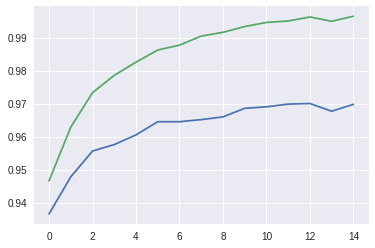

In [41]:
train(net, 15, X_train ,y_train ,X_test, y_test, 0.001)

1 эпоха:
test: 0.9707301587301588
train: 0.9974693877551021 




2 эпоха:
test: 0.9716825396825397
train: 0.9980680272108844 




3 эпоха:
test: 0.9713015873015873
train: 0.9980952380952381 




4 эпоха:
test: 0.9723174603174604
train: 0.9985034013605442 




5 эпоха:
test: 0.9715555555555555
train: 0.998639455782313 




6 эпоха:
test: 0.9721904761904762
train: 0.9987482993197279 




7 эпоха:
test: 0.9723174603174604
train: 0.9988299319727891 




8 эпоха:
test: 0.9724444444444444
train: 0.9988027210884354 




9 эпоха:
test: 0.9725079365079365
train: 0.998938775510204 




10 эпоха:
test: 0.9732698412698413
train: 0.998938775510204 




11 эпоха:
test: 0.9732063492063492
train: 0.9990204081632653 




12 эпоха:
test: 0.9723174603174604
train: 0.9990748299319728 




13 эпоха:
test: 0.9726984126984127
train: 0.9992380952380953 




14 эпоха:
test: 0.9735238095238096
train: 0.9992108843537415 




15 эпоха:
test: 0.9736507936507937
train: 0.999156462585034 




array([[3622,    0,    0,    1,    0,    0,    1,    0,    0,    0],
       [   0, 4132,    0,    1,    1,    0,    0,    1,    1,    0],
       [   1,    0, 3667,    0,    0,    0,    0,    1,    0,    0],
       [   0,    0,    0, 3747,    0,    0,    0,    1,    0,    1],
       [   1,    1,    0,    0, 3580,    0,    0,    1,    0,    0],
       [   0,    1,    0,    3,    0, 3306,    0,    2,    1,    1],
       [   1,    0,    0,    0,    0,    0, 3609,    0,    0,    0],
       [   1,    1,    1,    0,    0,    0,    0, 3823,    2,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0, 3583,    0],
       [   0,    0,    1,    0,    0,    0,    0,    2,    0, 3650]])

array([[1539,    1,    6,    0,    0,    0,    3,    0,    2,    2],
       [   0, 1746,   10,    3,    2,    0,    2,    5,    3,    1],
       [   6,    4, 1527,    6,    3,    2,    7,    7,    9,    2],
       [   2,    2,   17, 1546,    1,    9,    1,   14,   12,    3],
       [   0,    4,    8,    0, 1499,    2,    4,    1,    1,   16],
       [   4,    0,    3,   21,    1, 1363,    9,    1,   11,    8],
       [   7,    5,    3,    0,    5,    6, 1518,    0,    3,    0],
       [   2,    6,    6,    3,    7,    0,    0, 1610,    0,    7],
       [   9,    9,    6,   11,    4,   13,    5,    1, 1472,    6],
       [   5,    0,    0,    5,   11,    7,    1,   17,    4, 1515]])

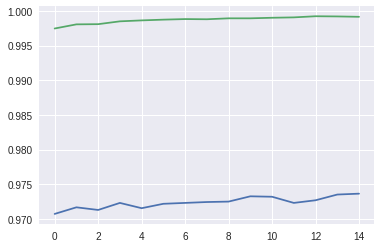

In [42]:
train(net, 15, X_train ,y_train ,X_test, y_test, 0.0005)

In [0]:
net = load_best_model()

In [18]:
# формируем сабмишшен и заливаем его на kaggle
net.set_train(False)
make_submission(X_site, net)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in exp


2
